In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
from moviepy.editor import VideoFileClip
%matplotlib inline

## Camera Calibration

In [2]:
# prepare object points
nx = 9 # enter the number of inside corners in x
ny = 6 # enter the number of inside corners in y

# Make a list of calibration images
# fname = 'camera_cal/calibration1.jpg'
# img = cv2.imread(fname)
# img = mpimg.imread(fname)
images = glob.glob('../camera_cal/calibration*.jpg')

# arrays to store object points and image points from all the images
imgpoints = [] # 2D points in image plane
objpoints = [] # 3D points in real world place

# prepare object points 
objp = np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x,y coordinates

for fname in images:

    img = mpimg.imread(fname)
    
    # convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    # find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray,(nx,ny),None)
    
    # if corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        # draw and display the corners
        img = cv2.drawChessboardCorners(img,(nx,ny),corners, ret)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

### Apply the distortion correction to calibrate camera images

In [3]:
# apply undistortion on test image
for fname in images:
    img = mpimg.imread(fname)
    
    dst = cv2.undistort(img,mtx,dist,None,mtx)
    dst_name = '../camera_cal/undist/' + fname.split('.jpg')[0].split('/')[-1] + '_dst.jpg'
    cv2.imwrite(dst_name,dst)
    
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
#     ax1.imshow(img)
#     ax1.set_title('Original Image', fontsize=30)
#     ax2.imshow(dst)
#     ax2.set_title('Undistorted Image', fontsize=30)


### Save the distortion matrices

In [4]:
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "../camera_cal/cal_dist_pickle.p", "wb" ) )

## Perspective Transformation

### Read saved distortion matrix from pickle file

In [5]:
dist_pickle = pickle.load( open( "../camera_cal/cal_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

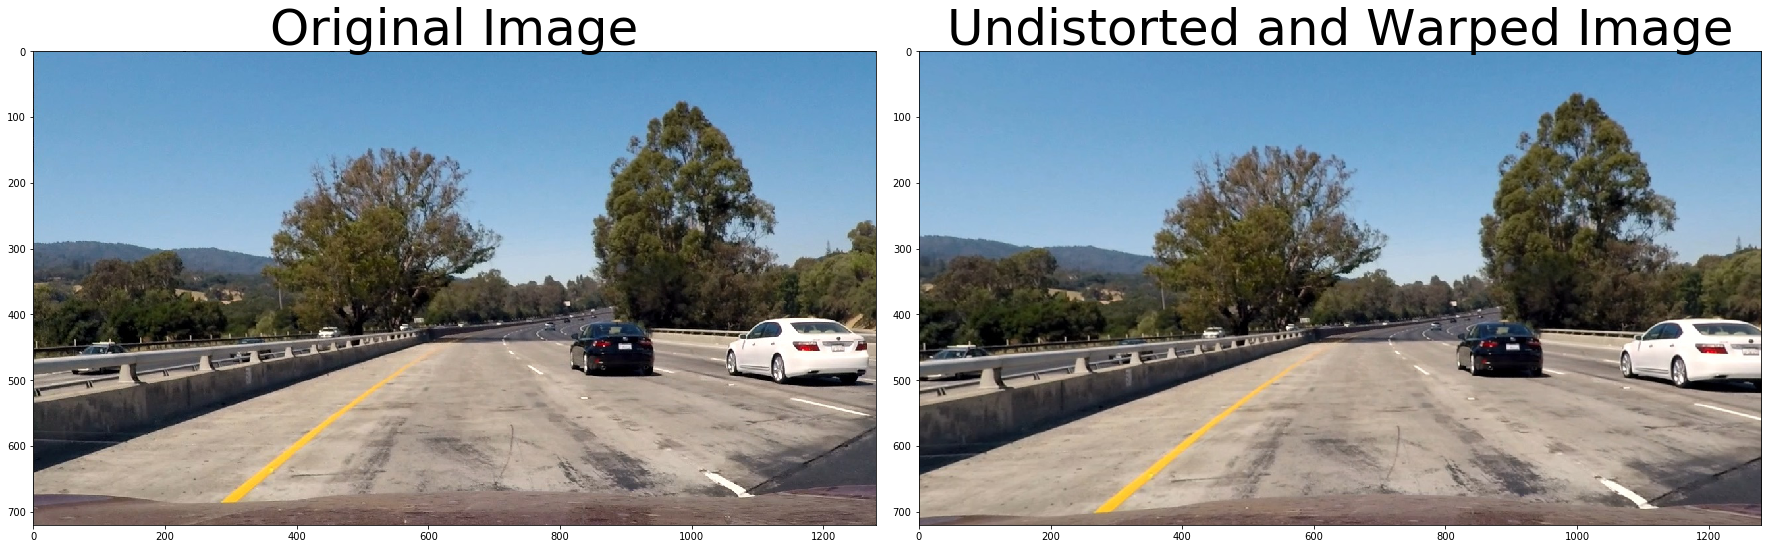

In [6]:
img = mpimg.imread('../test_images/test1.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


plt.savefig('../output_images/road_undist.png')

## Color and gradient threshold

### Gradient thresholding

In [7]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

### Combined with color thresholding

In [8]:
# pipeline for thresholding
def pipeline(img):
    
    img = np.copy(img)
    
    # apply gradient threshold on the horizontal gradient
    sx_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(10, 200))
    
    # apply gradient direction threshold 
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(np.pi/6, np.pi/2))
    
    # combine gradient and direction thresholds.
    combined_condition = ((sx_binary == 1) & (dir_binary == 1))
    
    # R & G thresholds to detect yellow lanes
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    r_g_condition = (R > color_threshold) & (G > color_threshold)
    
    # Convert to HSV color space 
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # S channel thresholding
    s_thresh = (100, 255)
    s_condition = (s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])
    
    # L channel thresholding to avoid pixels which have shadows 
    l_thresh = (120, 255)
    l_condition = (l_channel > l_thresh[0]) & (l_channel <= l_thresh[1])
    
    
    # combine all the thresholds
    combined_binary = np.zeros_like(R)
    combined_binary[(r_g_condition & l_condition) & (s_condition | combined_condition)] = 1
   
    return combined_binary
    

### Test the thresholding pipeline

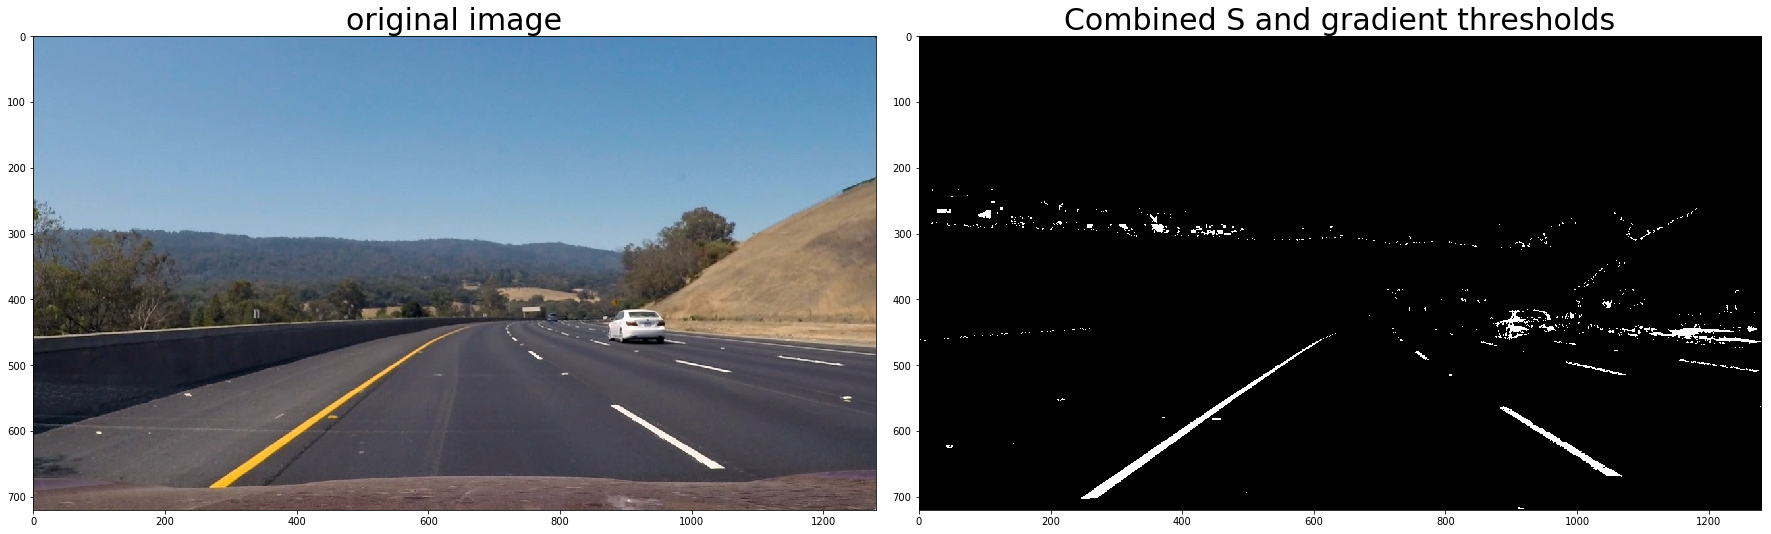

In [9]:
image = mpimg.imread('../test_images/test3.jpg')

undist = cv2.undistort(image, mtx, dist, None, mtx)

combined_binary = pipeline(undist)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('original image',fontsize=30)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Combined S and gradient thresholds', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig('../output_images/combined_binary_example.png')

### Perspective Transform

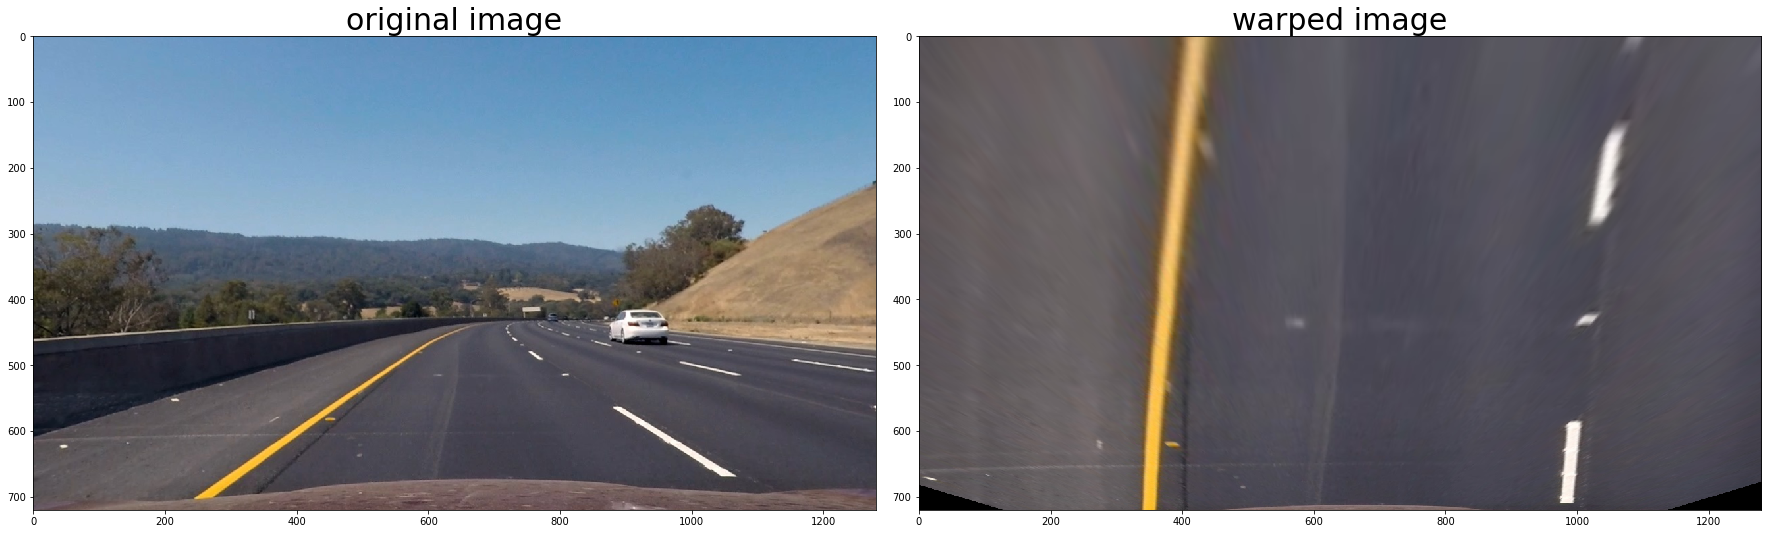

In [10]:
# First use straight line to identify four source points
img = mpimg.imread('../test_images/test3.jpg')

# Use the OpenCV undistort() function to remove distortion
undist = cv2.undistort(img, mtx, dist, None, mtx)

# define four source points
src = np.float32([[255.0,686.2],      # bottom left
                  [575.0,469.4],      # top left
                  [711.8,469.4],      # top right
                  [1044.7,686.2]])     # bottom right

# define corresponding destination points
dst = np.float32([[330,720],
                  [330,0],
                  [950,0],
                  [950,720]])


img_size = (img.shape[1],img.shape[0])

# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)

# Compute the inverse perspective transform:
Minv = cv2.getPerspectiveTransform(dst, src)

# Warp the image using OpenCV warpPerspective()
warped_image = cv2.warpPerspective(undist, M, img_size)

f, (ax1, ax2) = plt.subplots(1,2,figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('original image',fontsize=30)
ax2.imshow(warped_image, cmap='gray')
ax2.set_title('warped image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig('../output_images/warped_image.png')

### Window-based approach to find lane pixels

In [16]:
def findLanePixels_window(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Visualization of sliding window
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
#     # uncommented only if to plot results
#     f, (ax1, ax2) = plt.subplots(1,2,figsize=(24, 9))
#     f.tight_layout()
#     ax1.imshow(binary_warped,cmap='gray')
#     ax1.set_title('original lanes',fontsize=30)
#     ax2.imshow(out_img)
#     ax2.plot(left_fitx, ploty, color='yellow')
#     ax2.plot(right_fitx, ploty, color='yellow')
#     ax2.set_title('fitted lanes', fontsize=30)
#     plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#     plt.savefig('../output_images/color_fit_lines.png')

    return left_fit, right_fit, ploty, left_fitx, right_fitx

### Margin-based approach to find lanes

In [12]:
def findLanePixels_simple(binary_warped, left_fit, right_fit, margin = 100):

    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit, right_fit, ploty, left_fitx, right_fitx

### Visulize lane search results

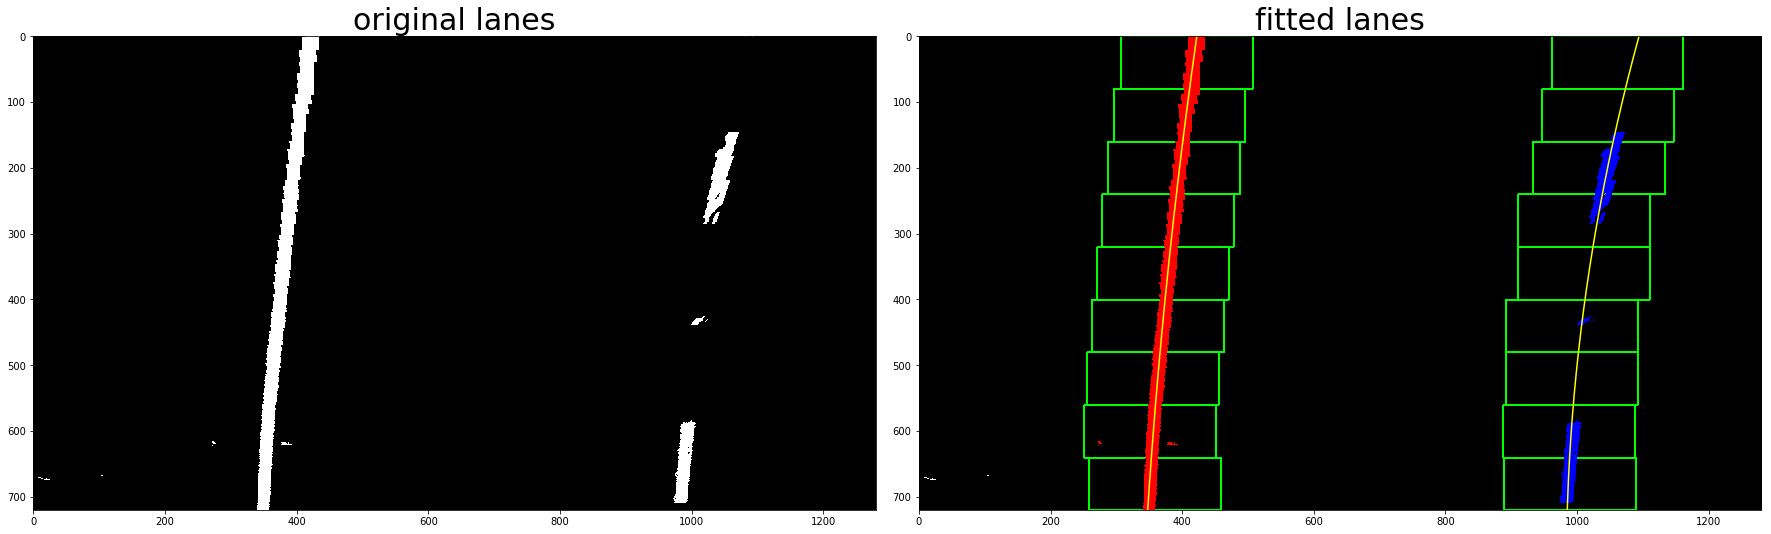

In [15]:
# first undist the image to remove distortion
img = mpimg.imread('../test_images/test3.jpg')

undist = cv2.undistort(img, mtx, dist, None, mtx)

# get threshold image using pipeline
combined_binary = pipeline(undist)

# define four source points
src = np.float32([[255.0,686.2],      # bottom left
                  [575.0,469.4],      # top left
                  [711.8,469.4],      # top right
                  [1044.7,686.2]])     # bottom right

dst = np.float32([[330,720],
                  [330,0],
                  [950,0],
                  [950,720]])

img_size = (img.shape[1],img.shape[0])

# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)

# Compute the inverse perspective transform:
Minv = cv2.getPerspectiveTransform(dst, src)

# Warp the image using OpenCV warpPerspective()
binary_warped = cv2.warpPerspective(combined_binary, M, img_size)

left_fit, right_fit, ploty, left_fitx, right_fitx = findLanePixels_window(binary_warped)



## Finding the radius curvature and offset of the car

In [17]:
def getCurvature(ploty, left_fitx, right_fitx):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return left_curverad, right_curverad

def getOffset(left_fitx, right_fitx, img_size):
    # compute the offset from the center
    lane_center = (left_fitx[-1] + right_fitx[-1])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels

    return center_offset_mtrs



## Map back to the road view and draw result

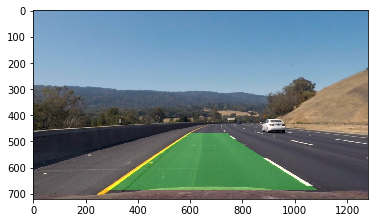

In [18]:
# def drawResult(binary_warped, ploty, left_fitx, right_fitx)
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 

# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)
plt.savefig('../output_images/example_output.png')

## Put it together - Video processing pipeline

In [19]:
def get_averaged_line(previous_lines, new_line):
    """
        This function computes an averaged lane line by averaging over previous good frames.
    """
    
    # Number of frames to save
    num_frames = 12
    
    if new_line is None:
        
        if len(previous_lines) == 0:
            # If there are no previous lines, return None
            return previous_lines, None
        else:
            # Else return the last line
            return previous_lines, previous_lines[-1]
    else:
        if len(previous_lines) < num_frames:
            # we need at least num_frames frames to average over
            previous_lines.append(new_line)
            return previous_lines, new_line
        else:
            # average over the last num_frames frames
            previous_lines[0:num_frames-1] = previous_lines[1:]
            previous_lines[num_frames-1] = new_line
            new_line = np.zeros_like(new_line)
            for i in range(num_frames):
                new_line += previous_lines[i]
            new_line /= num_frames
            return previous_lines, new_line

In [20]:
def advanced_lane_finding(img):
    
    # global variables to store the polynomial coefficients of the line detected in the last frame
    global left_fit
    global right_fit
    
    # global variables to store the line coordinates in previous n (=4) frames
    global past_good_right_lines
    global past_good_left_lines
    
    # global variable which contains running average of the mean difference between left and right lanes
    global running_mean_difference_between_lines
  
    # first undist the image to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)


    # get threshold image using pipeline
    combined_binary = pipeline(undist)

    # define four source points
    src = np.float32([[255.0,686.2],      # bottom left
                      [575.0,469.4],      # top left
                      [711.8,469.4],      # top right
                      [1044.7,686.2]])     # bottom right

    dst = np.float32([[330,720],
                      [330,0],
                      [950,0],
                      [950,720]])


    img_size = (img.shape[1],img.shape[0])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)

    # Compute the inverse perspective transform:
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Warp the image using OpenCV warpPerspective()
    binary_warped = cv2.warpPerspective(combined_binary, M, img_size)
    
    if (left_fit is not None) and (right_fit is not None):
        # if the polynomial coefficients of the previous frames are not none then perform simple search
        window = False
        margin = 100
        left_fit, right_fit, ploty, left_fitx, right_fitx = findLanePixels_simple(binary_warped,left_fit,right_fit,margin)
    else:
        # Else perform a window based search
        window = True
        left_fit, right_fit, ploty, left_fitx, right_fitx = findLanePixels_window(binary_warped)
    
    
    if (left_fitx is None or right_fitx is None):
        if not window:
            # if the window search hasn't been used
            left_fit, right_fit, ploty, left_fitx, right_fitx = findLanePixels_window(binary_warped)
            
    # sanity check if the deteced lines are good
    bad_lines = False
            
    if (left_fitx is None or right_fitx is None):
        bad_lines = True
    else:
        mean_difference = np.mean(right_fitx - left_fitx)
        
        if running_mean_difference_between_lines == 0:
            running_mean_difference_between_lines = mean_difference
        
        if (mean_difference < 0.7*running_mean_difference_between_lines or mean_difference > 1.3*running_mean_difference_between_lines):
            bad_lines = True
            if not window:
                left_fit, right_fit, ploty, left_fitx, right_fitx = findLanePixels_window(binary_warped)
                if (left_fitx is None or right_fitx is None):
                    bad_lines = True
                else:
                    mean_difference = np.mean(right_fitx - left_fitx)
                    if (mean_difference < 0.7*running_mean_difference_between_lines or mean_difference > 1.3*running_mean_difference_between_lines):
                        bad_lines = True
                    else:
                        bad_lines = False
        else:
            bad_lines = False
            
    if bad_lines:
        left_fit = None
        right_fit = None
        if len(past_good_left_lines) == 0 and len(past_good_right_lines) == 0:
            return img
        else:
            left_fitx = past_good_left_lines[-1]
            right_fitx = past_good_right_lines[-1]
    else:
        past_good_left_lines, left_fitx = get_averaged_line(past_good_left_lines, left_fitx)
        past_good_right_lines, right_fitx = get_averaged_line(past_good_right_lines, right_fitx)
        mean_difference = np.mean(right_fitx - left_fitx)
        running_mean_difference_between_lines = 0.9*running_mean_difference_between_lines + 0.1*mean_difference
        
    # compute the curvature for both left and right lanes
    left_curvature, right_curvature = getCurvature(ploty,left_fitx, right_fitx)
    offset = getOffset(left_fitx, right_fitx, img_size)
    
    average_curvature = (left_curvature + right_curvature)/2
    curvature_string = "Radius of curvature: {:.2f} m".format(average_curvature)
    offset_string = "Center offset: {:.2f} m".format(offset)
    
    #s Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    # add text to the image
    cv2.putText(result,curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    return result

    

#### Single image testing

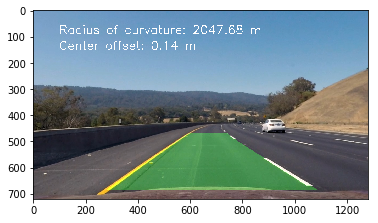

In [22]:
# First use straight line to identify four source points
img = mpimg.imread('../test_images/test3.jpg')

# Reinitialize some global variables.
left_fit = None
right_fit = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0

result = advanced_lane_finding(img)
plt.imshow(result)

### Test on video

In [23]:
# Reinitialize some global variables.
left_fit = None
right_fit = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0


output = '../project_video_output.mp4'
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(advanced_lane_finding) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ../project_video_output.mp4
[MoviePy] Writing video ../project_video_output.mp4


100%|█████████▉| 1260/1261 [03:48<00:00,  5.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../project_video_output.mp4 

CPU times: user 4min 13s, sys: 53.9 s, total: 5min 7s
Wall time: 3min 49s
